In [17]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip


URL transformed to HTTPS due to an HSTS policy
--2025-12-11 16:38:52--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip.2’

tiny-imagenet-200.z 100%[===================>] 236.61M  4.73MB/s    in 65s     

2025-12-11 16:39:57 (3.65 MB/s) - ‘tiny-imagenet-200.zip.2’ saved [248100043/248100043]

replace tiny-imagenet-200/words.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
y


In [18]:
SELECTED_CLASSES = [
    'n01629819',  # salamander
    'n01742172',  # black widow
    'n01644900',  # some frog
    'n01698610',  # alligator lizard
    'n02056570',  # king penguin
    'n01882714',  # koala
    'n02002724',  # black stork
    'n02085620',  # Chihuahua
    'n02123045',  # tabby cat
    'n02099601',  # golden retriever
]


Часть 1: Подготовка данных
Создание датакласса

Реализуйте собственный класс TinyImageNetDataset, наследующий от torch.utils.data.Dataset:

    Метод __init__: инициализация путей к данным, загрузка списка изображений и меток
    Метод __len__: возврат количества примеров в датасете
    Метод __getitem__: загрузка и возврат одного примера (изображение + метка)



In [19]:
!pip install light-the-torch
!ltt install torch torchvision

In [20]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
import glob
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

In [21]:
class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, selected_classes, split='train', transform=None):

        self.root_dir = root_dir
        self.selected_classes = selected_classes
        self.split = split
        self.transform = transform
        self.class_to_idx = {cls: idx for idx, cls in enumerate(selected_classes)}
        self.image_paths = []
        self.labels = []

        if split == 'train':
            self._load_train_data()
        elif split == 'val':
            self._load_val_data()

    def _load_train_data(self):
        train_dir = os.path.join(self.root_dir, 'train')

        for class_id in self.selected_classes:
            class_dir = os.path.join(train_dir, class_id, 'images')
            image_files = glob.glob(os.path.join(class_dir, '*.JPEG'))

            for img_path in image_files:
                self.image_paths.append(img_path)
                self.labels.append(self.class_to_idx[class_id])

    def _load_val_data(self):
        val_dir = os.path.join(self.root_dir, 'val')
        val_annotations_file = os.path.join(val_dir, 'val_annotations.txt')

        with open(val_annotations_file, 'r') as f:
            for line in f:
                parts = line.strip().split('\t')
                img_name = parts[0]
                class_id = parts[1]

                if class_id in self.selected_classes:
                    img_path = os.path.join(val_dir, 'images', img_name)
                    self.image_paths.append(img_path)
                    self.labels.append(self.class_to_idx[class_id])

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

    def __len__(self):
        return len(self.image_paths)

## Часть 2: Базовая архитектура ResNet18

### 2.1. Реализация Basic Block

Создайте базовый residual блок со следующей структурой:

```
Input
  ↓
Conv2d(kernel_size=3, padding=1, stride=stride)
  ↓
BatchNorm2d
  ↓
ReLU
  ↓
Conv2d(kernel_size=3, padding=1, stride=1)
  ↓
BatchNorm2d
  ↓
  + ← Skip Connection (с возможностью downsample)
  ↓
ReLU
  ↓
Output
```

**Важно:**
- Если входные и выходные размерности не совпадают, используйте skip connection с Conv2d(1x1) + BatchNorm2d
- Первый residual блок может иметь stride=2 для уменьшения пространственного размера

In [22]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        if self.downsample is not None:
            return self.relu(self.bn2(self.conv2(self.relu(self.bn1(self.conv1(x))))) + self.downsample(x))
        else:
            return self.relu(self.bn2(self.conv2(self.relu(self.bn1(self.conv1(x))))) + x)

### 2.2. Реализация ResNet18

Создайте архитектуру ResNet18 со следующей структурой:

```
Input (3, 64, 64)
  ↓
Conv2d(3→64, kernel_size=7, stride=2, padding=3)  # или 3x3, stride=1 для Tiny ImageNet
  ↓
BatchNorm2d
  ↓
ReLU
  ↓
MaxPool2d(kernel_size=3, stride=2, padding=1)  # опционально для Tiny ImageNet
  ↓
Layer1: 2x Basic Block (64 channels)
  ↓
Layer2: 2x Basic Block (128 channels, stride=2 в первом блоке)
  ↓
Layer3: 2x Basic Block (256 channels, stride=2 в первом блоке)
  ↓
Layer4: 2x Basic Block (512 channels, stride=2 в первом блоке)  # ОПЦИОНАЛЬНО
  ↓
AdaptiveAvgPool2d(output_size=(1, 1))
  ↓
Flatten
  ↓
Linear(512 → 10)  # 10 классов
  ↓
Output
```
### 2.3. Ограничения для базовой модели:

- **Общее количество параметров:** не более **5 миллионов**
- **Максимальное количество каналов:** до **512**


In [23]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(64, 64, num_blocks=2, stride=1)
        self.layer2 = self._make_layer(64, 128, num_blocks=2, stride=2)
        self.layer3 = self._make_layer(128, 256, num_blocks=2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []

        layers.append(BasicBlock(in_channels, out_channels, stride))

        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.fc(torch.flatten(self.avgpool(self.layer3(self.layer2(self.layer1(self.relu(self.bn1(self.conv1(x))))))), 1))


def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

model = ResNet18(num_classes=10)

total_params = count_parameters(model)
print("Total params N: ", total_params, " ", total_params/1e6, "M")

Total params N:  2777674   2.777674 M


### 2.4. Скрипт обучения

Реализуйте цикл обучения с следующими компонентами:

**Оптимизатор:**
- Adam или SGD
- Learning rate: 0.001

**Loss function:**
- CrossEntropyLoss

**Метрики:**
- Accuracy для train/validation
- Loss для train/validation

**Обучение:**
- Количество эпох: 20-30
- Логирование метрик на каждой эпохе


In [24]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)Ф
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def train_model(model, train_loader, val_loader, num_epochs=30, lr=0.001, device='cuda'):
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}] '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    return history

TINY_IMAGENET_PATH = '/content/tiny-imagenet-200'

train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = TinyImageNetDataset(TINY_IMAGENET_PATH, SELECTED_CLASSES, 'train', train_transform)
val_dataset = TinyImageNetDataset(TINY_IMAGENET_PATH, SELECTED_CLASSES, 'val', val_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device used: ", device)

model = ResNet18(num_classes=10)
print("params N: ", count_parameters(model))

history = train_model(model, train_loader, val_loader, num_epochs=20, lr=0.001, device=device)

device used:  cuda
params N:  2777674
Epoch [1/20] Train Loss: 1.9030, Train Acc: 30.44% | Val Loss: 1.7086, Val Acc: 29.78%
Epoch [2/20] Train Loss: 1.5921, Train Acc: 42.80% | Val Loss: 2.0504, Val Acc: 33.33%
Epoch [3/20] Train Loss: 1.4780, Train Acc: 48.07% | Val Loss: 1.6557, Val Acc: 41.56%
Epoch [4/20] Train Loss: 1.3768, Train Acc: 52.31% | Val Loss: 1.9517, Val Acc: 40.44%
Epoch [5/20] Train Loss: 1.3072, Train Acc: 53.20% | Val Loss: 1.4196, Val Acc: 50.44%
Epoch [6/20] Train Loss: 1.2171, Train Acc: 57.60% | Val Loss: 1.6755, Val Acc: 49.33%
Epoch [7/20] Train Loss: 1.1715, Train Acc: 59.13% | Val Loss: 1.4266, Val Acc: 48.44%
Epoch [8/20] Train Loss: 1.1195, Train Acc: 61.38% | Val Loss: 1.6096, Val Acc: 46.22%
Epoch [9/20] Train Loss: 1.0826, Train Acc: 62.69% | Val Loss: 1.3400, Val Acc: 49.56%
Epoch [10/20] Train Loss: 1.0325, Train Acc: 64.09% | Val Loss: 1.3206, Val Acc: 54.22%
Epoch [11/20] Train Loss: 0.9616, Train Acc: 66.84% | Val Loss: 1.7964, Val Acc: 45.78%
Epo

### 2.5: Визуализация базовых результатов

После обучения базовой модели создайте:

1. **График Accuracy:**
   - X: эпохи
   - Y: accuracy
   - Две линии: train и validation

2. **График Loss:**
   - X: эпохи
   - Y: loss
   - Две линии: train и validation

3. **Информация о модели:**
   - Общее количество параметров
   - Архитектура (выведите через print(model))


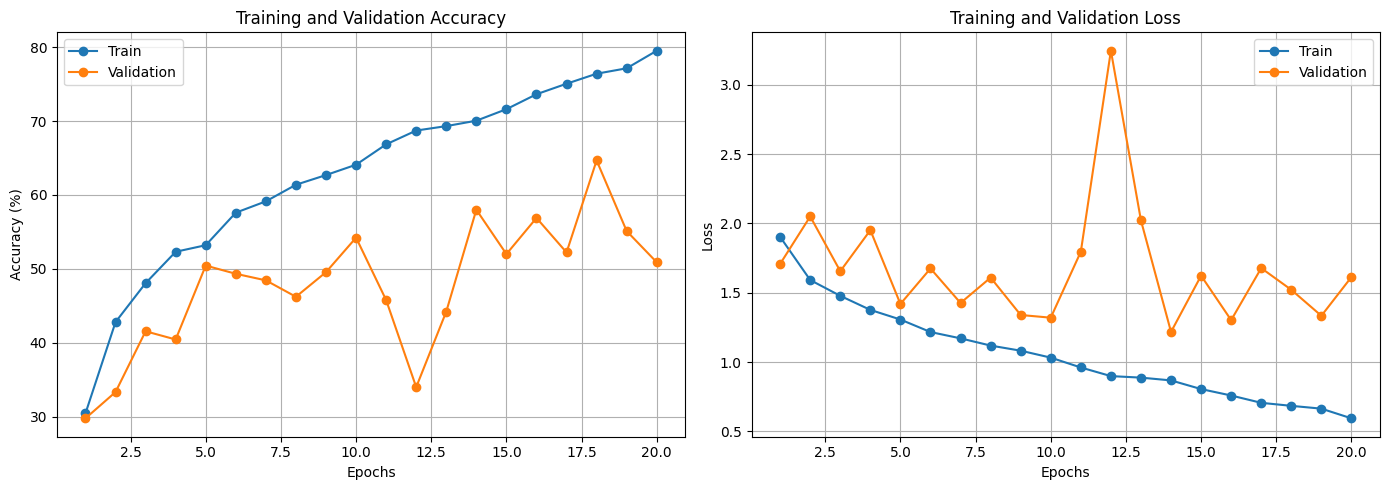

Params total N:  2777674

model: :
ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), str

In [25]:
import matplotlib.pyplot as plt

def plot_training_results(history):
    epochs = range(1, len(history['train_loss']) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(epochs, history['train_acc'], label='Train', marker='o')
    ax1.plot(epochs, history['val_acc'], label='Validation', marker='o')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_title('Training and Validation Accuracy')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(epochs, history['train_loss'], label='Train', marker='o')
    ax2.plot(epochs, history['val_loss'], label='Validation', marker='o')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.set_title('Training and Validation Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_results(history)

print("Params total N: ", count_parameters(model))
print("\nmodel: :")
print(model)

## Часть 3: Поэтапная оптимизация модели

### 3.1: Оптимизация количества каналов

**Цель:** Изучение влияния количества каналов на производительность.

**Эксперимент:**
- Создайте 2 варианта модели:
  - **Вариант A:** 32 → 64 → 128 → 256 каналов
  - **Вариант B:** 64 → 128 → 256 каналов (без 4-го слоя)
- Обучите обе модели с теми же гиперпараметрами
- Сравните:
  - Количество параметров
  - Validation accuracy

**Результат:**
- Таблица сравнения
- Графики accuracy и loss для обоих вариантов
- Вывод: какая конфигурация лучше?


Type A:
Количество параметров:  2797610
Epoch [1/20] Train Loss: 1.9004, Train Acc: 30.18% | Val Loss: 1.6056, Val Acc: 35.33%
Epoch [2/20] Train Loss: 1.5812, Train Acc: 43.24% | Val Loss: 2.1427, Val Acc: 31.56%
Epoch [3/20] Train Loss: 1.4226, Train Acc: 48.11% | Val Loss: 1.4350, Val Acc: 46.22%
Epoch [4/20] Train Loss: 1.3130, Train Acc: 53.42% | Val Loss: 1.4729, Val Acc: 44.00%
Epoch [5/20] Train Loss: 1.2078, Train Acc: 56.49% | Val Loss: 1.4937, Val Acc: 50.22%
Epoch [6/20] Train Loss: 1.1124, Train Acc: 60.51% | Val Loss: 1.2270, Val Acc: 52.67%
Epoch [7/20] Train Loss: 1.0583, Train Acc: 61.49% | Val Loss: 1.2738, Val Acc: 52.67%
Epoch [8/20] Train Loss: 0.9587, Train Acc: 65.29% | Val Loss: 1.2109, Val Acc: 56.00%
Epoch [9/20] Train Loss: 0.9130, Train Acc: 67.02% | Val Loss: 1.1304, Val Acc: 54.89%
Epoch [10/20] Train Loss: 0.7943, Train Acc: 71.67% | Val Loss: 1.7348, Val Acc: 42.67%
Epoch [11/20] Train Loss: 0.6934, Train Acc: 75.80% | Val Loss: 1.6025, Val Acc: 53.78%
E

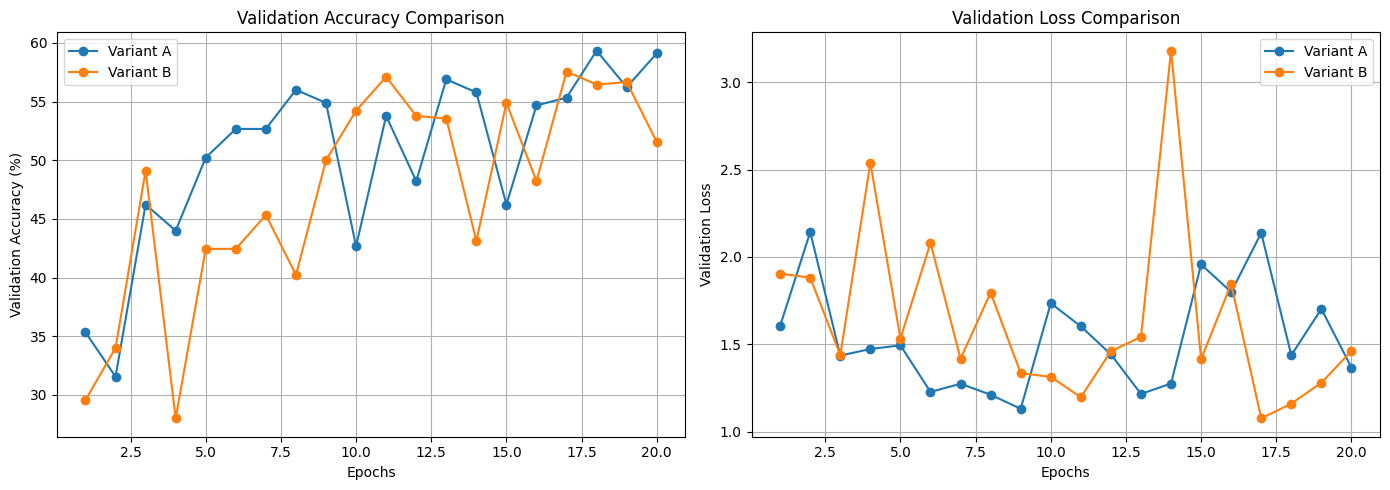

In [26]:
class ResNet18_VariantA(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18_VariantA, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(32, 32, num_blocks=2, stride=1)
        self.layer2 = self._make_layer(32, 64, num_blocks=2, stride=2)
        self.layer3 = self._make_layer(64, 128, num_blocks=2, stride=2)
        self.layer4 = self._make_layer(128, 256, num_blocks=2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.fc(torch.flatten(self.avgpool(self.layer4(self.layer3(self.layer2(self.layer1(self.relu(self.bn1(self.conv1(x)))))))), 1))

class ResNet18_VariantB(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18_VariantB, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(64, 64, num_blocks=2, stride=1)
        self.layer2 = self._make_layer(64, 128, num_blocks=2, stride=2)
        self.layer3 = self._make_layer(128, 256, num_blocks=2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.fc(torch.flatten(self.avgpool(self.layer3(self.layer2(self.layer1(self.relu(self.bn1(self.conv1(x))))))), 1))

print("Type A:")
model_A = ResNet18_VariantA(num_classes=10)
print("Количество параметров: ", count_parameters(model_A))

history_A = train_model(model_A, train_loader, val_loader, num_epochs=20, lr=0.001, device=device)

print("Type B:")
model_B = ResNet18_VariantB(num_classes=10)
print("Количество параметров: ", count_parameters(model_B))

history_B = train_model(model_B, train_loader, val_loader, num_epochs=20, lr=0.001, device=device)

print("Type A - params: ", count_parameters(model_A), "Val Accuracy: ", max(history_A['val_acc']))
print("Type B - params:", count_parameters(model_B), "Val Accuracy: ", max(history_B['val_acc']))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

epochs = range(1, len(history_A['train_acc']) + 1)

ax1.plot(epochs, history_A['val_acc'], label='Variant A', marker='o')
ax1.plot(epochs, history_B['val_acc'], label='Variant B', marker='o')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Validation Accuracy (%)')
ax1.set_title('Validation Accuracy Comparison')
ax1.legend()
ax1.grid(True)

ax2.plot(epochs, history_A['val_loss'], label='Variant A', marker='o')
ax2.plot(epochs, history_B['val_loss'], label='Variant B', marker='o')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Validation Loss')
ax2.set_title('Validation Loss Comparison')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

### 3.2: Эксперименты с количеством residual блоков

**Цель:** Изучение влияния глубины сети (количества residual блоков) на производительность.

**Эксперимент:**
- Используйте лучшую конфигурацию каналов из Этапа 3.1
- Создайте 3 варианта модели с разным количеством блоков в каждом слое:
  - **Вариант A:** [1, 1, 1, 1] - по 1 блоку в каждом слое (мелкая сеть)
  - **Вариант B:** [2, 2, 2, 2] - по 2 блока в каждом слое (стандартная ResNet18)
  - **Вариант C:** [3, 3, 3, 3] - по 3 блока в каждом слое (глубокая сеть)
- Обучите все три модели с одинаковыми гиперпараметрами

**Архитектура вариантов:**
```
Вариант A (4 блока):  Layer1[1 блок] → Layer2[1 блок] → Layer3[1 блок] → Layer4[1 блок]
Вариант B (8 блоков): Layer1[2 блока] → Layer2[2 блока] → Layer3[2 блока] → Layer4[2 блока]
Вариант C (12 блоков): Layer1[3 блока] → Layer2[3 блока] → Layer3[3 блока] → Layer4[3 блока]
```

**Результат:**
- Сравните:
  - Количество параметров
  - Validation accuracy
  - Скорость сходимости (на каких эпохах модель достигает лучших результатов)
- Графики accuracy для всех трех вариантов на одном графике
- Анализ: какая глубина оптимальна? Есть ли переобучение у более глубоких моделей?
- Вывод: какое количество блоков работает лучше?


Type A:
Params N:  1228970
Epoch [1/20] Train Loss: 1.8448, Train Acc: 32.69% | Val Loss: 1.9937, Val Acc: 25.56%
Epoch [2/20] Train Loss: 1.5412, Train Acc: 45.76% | Val Loss: 1.6738, Val Acc: 41.78%
Epoch [3/20] Train Loss: 1.3854, Train Acc: 50.38% | Val Loss: 1.6406, Val Acc: 41.78%
Epoch [4/20] Train Loss: 1.2515, Train Acc: 56.36% | Val Loss: 1.4534, Val Acc: 44.22%
Epoch [5/20] Train Loss: 1.1470, Train Acc: 59.87% | Val Loss: 1.2011, Val Acc: 52.00%
Epoch [6/20] Train Loss: 1.0327, Train Acc: 64.44% | Val Loss: 1.6487, Val Acc: 47.78%
Epoch [7/20] Train Loss: 0.9287, Train Acc: 66.87% | Val Loss: 1.4994, Val Acc: 48.00%
Epoch [8/20] Train Loss: 0.8275, Train Acc: 70.38% | Val Loss: 1.2942, Val Acc: 55.56%
Epoch [9/20] Train Loss: 0.7192, Train Acc: 75.04% | Val Loss: 2.2967, Val Acc: 42.89%
Epoch [10/20] Train Loss: 0.6190, Train Acc: 78.11% | Val Loss: 2.6050, Val Acc: 42.44%
Epoch [11/20] Train Loss: 0.5068, Train Acc: 82.49% | Val Loss: 1.8443, Val Acc: 48.67%
Epoch [12/20] 

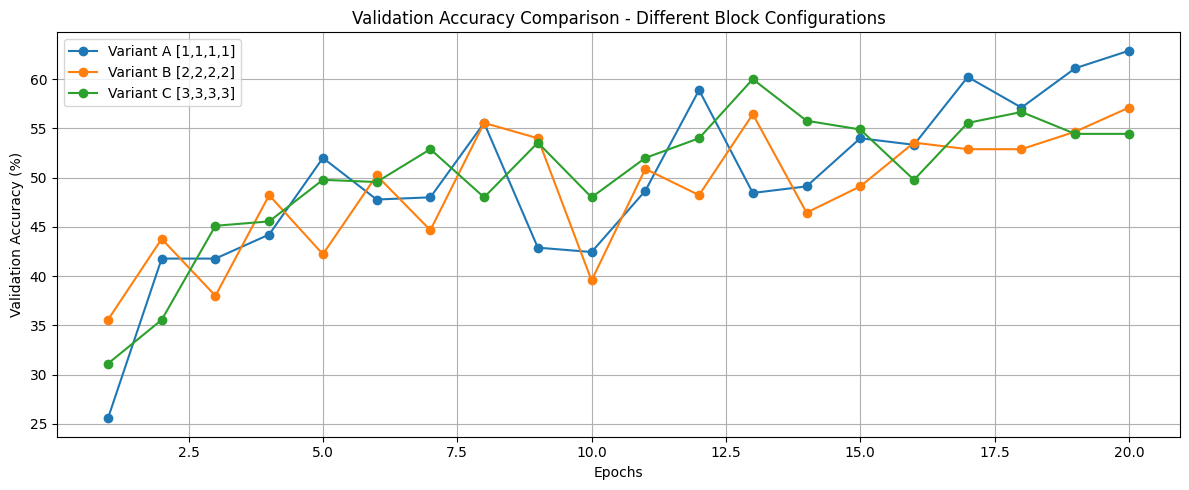

In [27]:
class ResNet18_Flexible(nn.Module):
    def __init__(self, num_classes=10, num_blocks=[2, 2, 2, 2]):
        super(ResNet18_Flexible, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(32, 32, num_blocks=num_blocks[0], stride=1)
        self.layer2 = self._make_layer(32, 64, num_blocks=num_blocks[1], stride=2)
        self.layer3 = self._make_layer(64, 128, num_blocks=num_blocks[2], stride=2)
        self.layer4 = self._make_layer(128, 256, num_blocks=num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.fc(torch.flatten(self.avgpool(self.layer4(self.layer3(self.layer2(self.layer1(self.relu(self.bn1(self.conv1(x)))))))), 1))


# A:
print("Type A:")
model_blocks_A = ResNet18_Flexible(num_classes=10, num_blocks=[1, 1, 1, 1])
print("Params N: ", count_parameters(model_blocks_A))

history_blocks_A = train_model(model_blocks_A, train_loader, val_loader, num_epochs=20, lr=0.001, device=device)

# B:
print("Type B:")
model_blocks_B = ResNet18_Flexible(num_classes=10, num_blocks=[2, 2, 2, 2])
print("Params N: ", count_parameters(model_blocks_B))

history_blocks_B = train_model(model_blocks_B, train_loader, val_loader, num_epochs=20, lr=0.001, device=device)

# C:
print("Type C:")
model_blocks_C = ResNet18_Flexible(num_classes=10, num_blocks=[3, 3, 3, 3])
print("Params N: ", count_parameters(model_blocks_C))

history_blocks_C = train_model(model_blocks_C, train_loader, val_loader, num_epochs=20, lr=0.001, device=device)

print("Type A [1,1,1,1] - Val Accuracy: ", max(history_blocks_A['val_acc']))
print("Type B [2,2,2,2] - Val Accuracy: ", max(history_blocks_B['val_acc']))
print("Type C [3,3,3,3] - Val Accuracy: ", max(history_blocks_C['val_acc']))

plt.figure(figsize=(12, 5))

epochs = range(1, len(history_blocks_A['val_acc']) + 1)

plt.plot(epochs, history_blocks_A['val_acc'], label='Variant A [1,1,1,1]', marker='o')
plt.plot(epochs, history_blocks_B['val_acc'], label='Variant B [2,2,2,2]', marker='o')
plt.plot(epochs, history_blocks_C['val_acc'], label='Variant C [3,3,3,3]', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy (%)')
plt.title('Validation Accuracy Comparison - Different Block Configurations')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 3.3: Эксперименты с функциями активации

**Цель:** Исследование влияния различных активаций на обучение.

**Модификация модели:**
Замените ReLU на другие функции активации:

**Эксперимент:**
- Используйте лучшую конфигурацию из Этапа 3.2 (каналы + количество блоков)
- Обучите модели с разными активациями:
  - **Вариант A:** ReLU (baseline)
  - **Вариант B:** LeakyReLU
  - **Вариант C:** ELU
  - **Вариант D:** GELU

**Важно:** Используйте `inplace=True` где возможно для экономии памяти

**Результат:**
- Сравнение скорости сходимости (accuracy на каждой эпохе)
- Финальная validation accuracy
- Вывод: какая активация работает лучше?



Type A: ReLU
Params N:  1228970
Epoch [1/20] Train Loss: 1.8194, Train Acc: 33.91% | Val Loss: 2.3711, Val Acc: 27.78%
Epoch [2/20] Train Loss: 1.5041, Train Acc: 47.44% | Val Loss: 3.4855, Val Acc: 26.67%
Epoch [3/20] Train Loss: 1.3637, Train Acc: 52.33% | Val Loss: 2.0990, Val Acc: 36.22%
Epoch [4/20] Train Loss: 1.2422, Train Acc: 56.80% | Val Loss: 1.4407, Val Acc: 51.33%
Epoch [5/20] Train Loss: 1.1529, Train Acc: 59.33% | Val Loss: 1.5591, Val Acc: 46.89%
Epoch [6/20] Train Loss: 1.0411, Train Acc: 63.38% | Val Loss: 1.4511, Val Acc: 46.89%
Epoch [7/20] Train Loss: 0.9674, Train Acc: 65.91% | Val Loss: 1.4559, Val Acc: 48.22%
Epoch [8/20] Train Loss: 0.8566, Train Acc: 70.20% | Val Loss: 1.8597, Val Acc: 50.00%
Epoch [9/20] Train Loss: 0.7540, Train Acc: 74.07% | Val Loss: 1.6589, Val Acc: 45.56%
Epoch [10/20] Train Loss: 0.6439, Train Acc: 78.00% | Val Loss: 1.5830, Val Acc: 50.00%
Epoch [11/20] Train Loss: 0.5465, Train Acc: 80.87% | Val Loss: 1.3112, Val Acc: 54.67%
Epoch [12

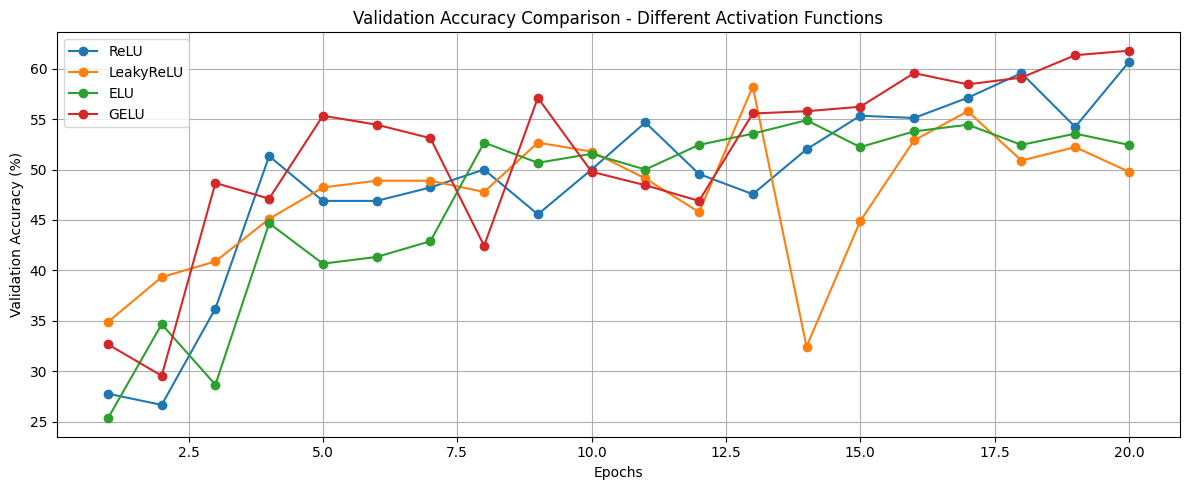

In [28]:
class BasicBlock_CustomActivation(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, activation='relu'):
        super(BasicBlock_CustomActivation, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # select activation func
        if activation == 'relu':
            self.activation = nn.ReLU(inplace=True)
        elif activation == 'leakyrelu':
            self.activation = nn.LeakyReLU(inplace=True)
        elif activation == 'elu':
            self.activation = nn.ELU(inplace=True)
        elif activation == 'gelu':
            self.activation = nn.GELU()

        # Skip conn
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.activation(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.activation(out)

        return out

class ResNet18_CustomActivation(nn.Module):
    def __init__(self, num_classes=10, activation='relu'):
        super(ResNet18_CustomActivation, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)

        if activation == 'relu':
            self.activation = nn.ReLU(inplace=True)
        elif activation == 'leakyrelu':
            self.activation = nn.LeakyReLU(inplace=True)
        elif activation == 'elu':
            self.activation = nn.ELU(inplace=True)
        elif activation == 'gelu':
            self.activation = nn.GELU()

        self.layer1 = self._make_layer(32, 32, num_blocks=1, stride=1, activation=activation)
        self.layer2 = self._make_layer(32, 64, num_blocks=1, stride=2, activation=activation)
        self.layer3 = self._make_layer(64, 128, num_blocks=1, stride=2, activation=activation)
        self.layer4 = self._make_layer(128, 256, num_blocks=1, stride=2, activation=activation)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride, activation):
        layers = []
        layers.append(BasicBlock_CustomActivation(in_channels, out_channels, stride=stride, activation=activation))
        for _ in range(1, num_blocks):
            layers.append(BasicBlock_CustomActivation(out_channels, out_channels, stride=1, activation=activation))
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.fc(torch.flatten(self.avgpool(self.layer4(self.layer3(self.layer2(self.layer1(self.activation(self.bn1(self.conv1(x)))))))), 1))

print("Type A: ReLU")
model_relu = ResNet18_CustomActivation(num_classes=10, activation='relu')
print("Params N: ", count_parameters(model_relu))

history_relu = train_model(model_relu, train_loader, val_loader, num_epochs=20, lr=0.001, device=device)

print("Type B: LeakyReLU")
model_leakyrelu = ResNet18_CustomActivation(num_classes=10, activation='leakyrelu')
print("Params N: ", count_parameters(model_leakyrelu))

history_leakyrelu = train_model(model_leakyrelu, train_loader, val_loader, num_epochs=20, lr=0.001, device=device)

print("Type C: ELU")
model_elu = ResNet18_CustomActivation(num_classes=10, activation='elu')
print("Params N: ", count_parameters(model_elu))

history_elu = train_model(model_elu, train_loader, val_loader, num_epochs=20, lr=0.001, device=device)

print("Type D: GELU")
model_gelu = ResNet18_CustomActivation(num_classes=10, activation='gelu')
print("Params N: ", count_parameters(model_gelu))

history_gelu = train_model(model_gelu, train_loader, val_loader, num_epochs=20, lr=0.001, device=device)

print("ReLU - Val Accuracy: ", max(history_relu['val_acc']))
print("LeakyReLU - Val Accuracy: ", max(history_leakyrelu['val_acc']))
print("ELU - Val Accuracy: ", max(history_elu['val_acc']))
print("GELU - Val Accuracy: ", max(history_gelu['val_acc']))

plt.figure(figsize=(12, 5))

epochs = range(1, len(history_relu['val_acc']) + 1)

plt.plot(epochs, history_relu['val_acc'], label='ReLU', marker='o')
plt.plot(epochs, history_leakyrelu['val_acc'], label='LeakyReLU', marker='o')
plt.plot(epochs, history_elu['val_acc'], label='ELU', marker='o')
plt.plot(epochs, history_gelu['val_acc'], label='GELU', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy (%)')
plt.title('Validation Accuracy Comparison - Different Activation Functions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Часть 4: Финальная модель и тестирование

### 4.1: Создание финальной модели

На основе всех экспериментов:
- Выберите лучшую конфигурацию каналов (из Этапа 3.1)
- Выберите оптимальное количество residual блоков (из Этапа 3.2) - объясните, почему выбрали именно это количество
- Выберите лучшую функцию активации (из Этапа 3.3)
- Обучите финальную модель на 30-40 эпох с выбранными параметрами

**Дополнительно (опционально):**
- Добавьте data augmentation
- Попробуйте другие оптимизаторы (AdamW как вариант)

final model: 
- Channels: 32 → 64 → 128 → 256
- Blocks N: [1, 1, 1, 1]
- Activation: GELU

Params N:  1228970
Epoch [1/30] Train Loss: 1.7755, Train Acc: 35.64% | Val Loss: 1.6233, Val Acc: 34.44%
Epoch [2/30] Train Loss: 1.4797, Train Acc: 46.64% | Val Loss: 1.5011, Val Acc: 46.44%
Epoch [3/30] Train Loss: 1.3142, Train Acc: 53.16% | Val Loss: 1.4806, Val Acc: 45.56%
Epoch [4/30] Train Loss: 1.1973, Train Acc: 57.80% | Val Loss: 1.5582, Val Acc: 40.22%
Epoch [5/30] Train Loss: 1.0633, Train Acc: 62.87% | Val Loss: 1.3461, Val Acc: 45.56%
Epoch [6/30] Train Loss: 0.9478, Train Acc: 66.20% | Val Loss: 1.3033, Val Acc: 54.89%
Epoch [7/30] Train Loss: 0.8356, Train Acc: 70.80% | Val Loss: 1.7491, Val Acc: 41.56%
Epoch [8/30] Train Loss: 0.7272, Train Acc: 74.73% | Val Loss: 1.4446, Val Acc: 49.56%
Epoch [9/30] Train Loss: 0.5928, Train Acc: 79.98% | Val Loss: 1.6527, Val Acc: 51.78%
Epoch [10/30] Train Loss: 0.4071, Train Acc: 86.64% | Val Loss: 1.3321, Val Acc: 56.44%
Epoch [11/30] Train

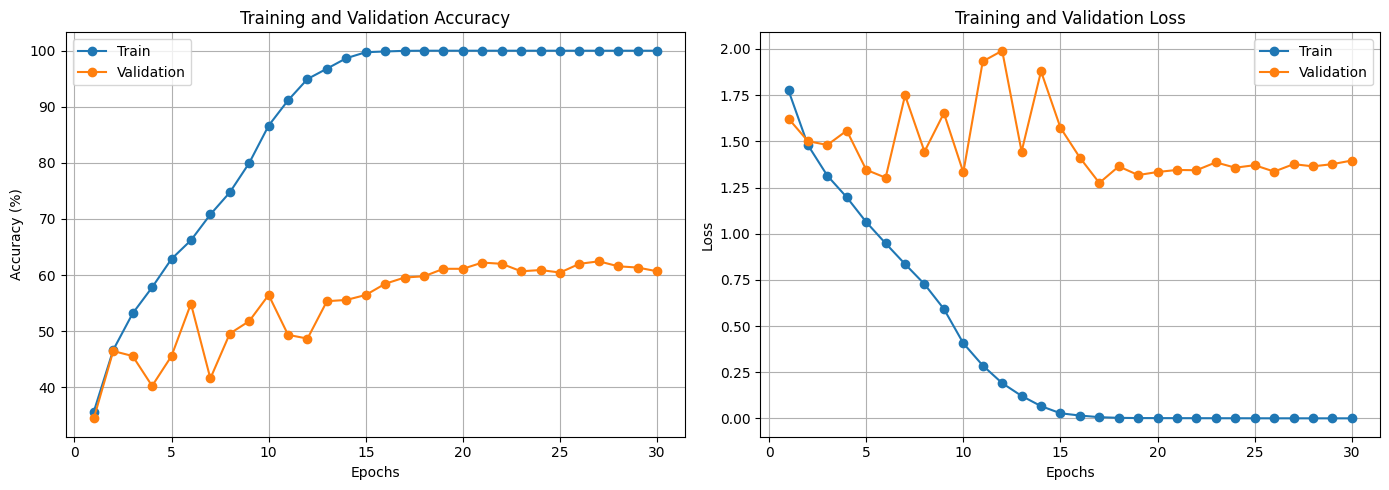

In [29]:
class FinalResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(FinalResNet18, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.activation = nn.GELU()

        self.layer1 = self._make_layer(32, 32, num_blocks=1, stride=1)
        self.layer2 = self._make_layer(32, 64, num_blocks=1, stride=2)
        self.layer3 = self._make_layer(64, 128, num_blocks=1, stride=2)
        self.layer4 = self._make_layer(128, 256, num_blocks=1, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(BasicBlock_CustomActivation(in_channels, out_channels, stride=stride, activation='gelu'))
        for _ in range(1, num_blocks):
            layers.append(BasicBlock_CustomActivation(out_channels, out_channels, stride=1, activation='gelu'))
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.fc(torch.flatten(self.avgpool(self.layer4(self.layer3(self.layer2(self.layer1(self.activation(self.bn1(self.conv1(x)))))))), 1))

print("final model: ")
print("- Channels: 32 → 64 → 128 → 256")
print("- Blocks N: [1, 1, 1, 1]")
print("- Activation: GELU")

final_model = FinalResNet18(num_classes=10)
print("\nParams N: ", count_parameters(final_model))

final_history = train_model(final_model, train_loader, val_loader, num_epochs=30, lr=0.001, device=device)

best_val_acc = max(final_history['val_acc'])
best_epoch = final_history['val_acc'].index(best_val_acc) + 1
print("\nBest Val accuracy: ", best_val_acc, "epoch: ", best_epoch)

plot_training_results(final_history)

### 4.2: Тестирование на test set

После обучения финальной модели:

1. **Загрузите лучшую модель** (сохраненную по validation accuracy)
2. **Оцените на test set:**
   - Accuracy
   - Precision, Recall, F1-score для каждого класса
   - Confusion Matrix

Test Accuracy:  60.666666666666664
Class metrics
              precision    recall  f1-score   support

     Class 0     0.9070    0.7800    0.8387        50
     Class 1     0.4250    0.3400    0.3778        50
     Class 2     0.5926    0.6400    0.6154        50
     Class 4     0.7368    0.8400    0.7850        50
     Class 5     0.6327    0.6200    0.6263        50
     Class 6     0.6271    0.7400    0.6789        50
     Class 7     0.4865    0.3600    0.4138        50
     Class 8     0.4681    0.4400    0.4536        50
     Class 9     0.5469    0.7000    0.6140        50

    accuracy                         0.6067       450
   macro avg     0.6025    0.6067    0.6004       450
weighted avg     0.6025    0.6067    0.6004       450

CONFUSION MATRIX



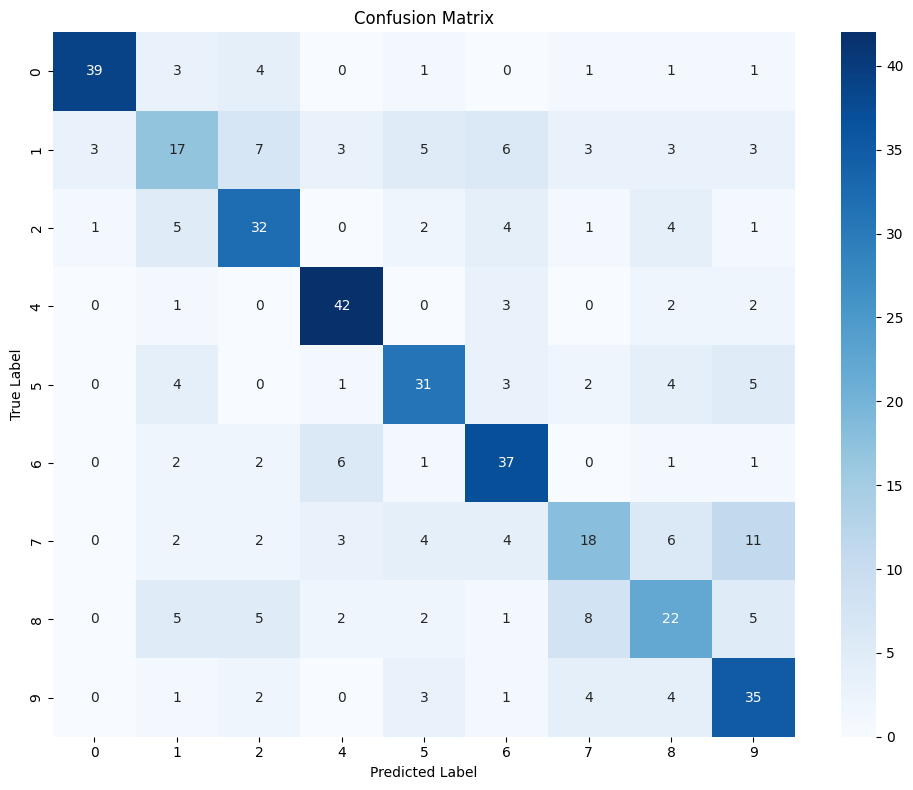

In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

def evaluate_model(model, test_loader, device):
    """test set"""
    model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    return accuracy, all_preds, all_labels

test_accuracy, test_preds, test_labels = evaluate_model(final_model, val_loader, device)

print("Test Accuracy: ", test_accuracy)

print("Class metrics")

unique_classes = sorted(np.unique(test_labels))
target_names = [f'Class {i}' for i in unique_classes]

print(classification_report(test_labels, test_preds, labels=unique_classes,
                           target_names=target_names, digits=4))

print("CONFUSION MATRIX\n")

cm = confusion_matrix(test_labels, test_preds, labels=unique_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

### 4.3: Визуальный анализ

Создайте визуализацию с 10 случайными примерами из test set:

```
[Изображение 1] | Истинный класс: cat    | Предсказание: cat
[Изображение 2] | Истинный класс: dog    | Предсказание: wolf
...
```

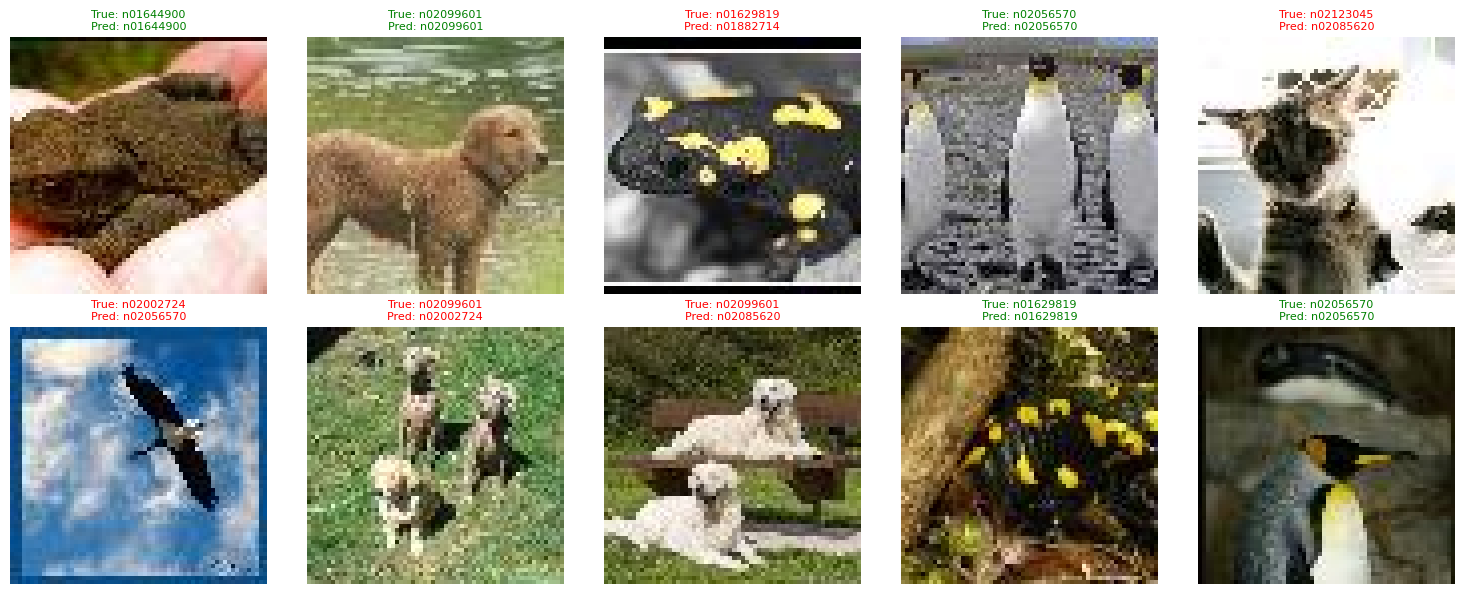

In [31]:
import random

def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """Denormalizing"""
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return torch.clamp(tensor, 0, 1)

def visualize_predictions(model, dataset, device, num_samples=10):
    """random examples visualization"""
    model.eval()

    indices = random.sample(range(len(dataset)), num_samples)

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()

    class_names = SELECTED_CLASSES

    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, true_label = dataset[idx]

            # predict
            image_batch = image.unsqueeze(0).to(device)
            output = model(image_batch)
            _, predicted = output.max(1)
            pred_label = predicted.item()

            # Denormalizing
            img_display = denormalize(image)
            img_display = img_display.permute(1, 2, 0).numpy()

            # Visualizing
            axes[i].imshow(img_display)
            axes[i].axis('off')

            true_class = class_names[true_label]
            pred_class = class_names[pred_label]

            color = 'green' if true_label == pred_label else 'red'
            axes[i].set_title(f'True: {true_class}\nPred: {pred_class}',
                            fontsize=8, color=color)

    plt.tight_layout()
    plt.show()

visualize_predictions(final_model, val_dataset, device, num_samples=10)

### 4.4: Сравнительная таблица всех экспериментов

Создайте итоговую таблицу со всеми результатами:

| Этап | Конфигурация | Параметры | Val Accuracy | Train Accuracy |
|------|--------------|-----------|--------------|----------------|
| **Baseline** | Ваша базовая модель | X.XM | XX.X% | XX.X% |
| **3.1-A** | 32→64→128→256 | X.XM | XX.X% | XX.X% |
| **3.1-B** | 64→128→256 | X.XM | XX.X% | XX.X% |
| **3.2-A** | [1,1,1,1] блоков | X.XM | XX.X% | XX.X% |
| **3.2-B** | [2,2,2,2] блоков | X.XM | XX.X% | XX.X% |
| **3.2-C** | [3,3,3,3] блоков | X.XM | XX.X% | XX.X% |
| **3.3-A** | ReLU | X.XM | XX.X% | XX.X% |
| **3.3-B** | LeakyReLU | X.XM | XX.X% | XX.X% |
| **3.3-C** | ELU | X.XM | XX.X% | XX.X% |
| **3.3-D** | GELU | X.XM | XX.X% | XX.X% |
| **Final** | Лучшая конфигурация | X.XM | XX.X% | XX.X% |

**Анализ:**
- Какая конфигурация показала лучший результат?
- Есть ли признаки переобучения (большая разница между train и val)?

In [32]:


import pandas as pd

data = {
    'Stage': [
        'Baseline',
        '3.1-A',
        '3.1-B',
        '3.2-A',
        '3.2-B',
        '3.2-C',
        '3.3-A',
        '3.3-B',
        '3.3-C',
        '3.3-D',
        'Final'
    ],
    'Configuration': [
        '64→128→256',
        '32→64→128→256',
        '64→128→256',
        '[1,1,1,1] blocks',
        '[2,2,2,2] blocks',
        '[3,3,3,3] blocks',
        'ReLU',
        'LeakyReLU',
        'ELU',
        'GELU',
        '32→64→128→256, [1,1,1,1], GELU'
    ],
    'Params': [
        f'{count_parameters(model_B)/1e6:.2f}M',
        f'{count_parameters(model_A)/1e6:.2f}M',
        f'{count_parameters(model_B)/1e6:.2f}M',
        f'{count_parameters(model_blocks_A)/1e6:.2f}M',
        f'{count_parameters(model_blocks_B)/1e6:.2f}M',
        f'{count_parameters(model_blocks_C)/1e6:.2f}M',
        f'{count_parameters(model_relu)/1e6:.2f}M',
        f'{count_parameters(model_leakyrelu)/1e6:.2f}M',
        f'{count_parameters(model_elu)/1e6:.2f}M',
        f'{count_parameters(model_gelu)/1e6:.2f}M',
        f'{count_parameters(final_model)/1e6:.2f}M'
    ],
    'Val Accuracy': [
        f'{max(history_B["val_acc"]):.2f}%',
        f'{max(history_A["val_acc"]):.2f}%',
        f'{max(history_B["val_acc"]):.2f}%',
        f'{max(history_blocks_A["val_acc"]):.2f}%',
        f'{max(history_blocks_B["val_acc"]):.2f}%',
        f'{max(history_blocks_C["val_acc"]):.2f}%',
        f'{max(history_relu["val_acc"]):.2f}%',
        f'{max(history_leakyrelu["val_acc"]):.2f}%',
        f'{max(history_elu["val_acc"]):.2f}%',
        f'{max(history_gelu["val_acc"]):.2f}%',
        f'{max(final_history["val_acc"]):.2f}%'
    ],
    'Train Accuracy': [
        f'{max(history_B["train_acc"]):.2f}%',
        f'{max(history_A["train_acc"]):.2f}%',
        f'{max(history_B["train_acc"]):.2f}%',
        f'{max(history_blocks_A["train_acc"]):.2f}%',
        f'{max(history_blocks_B["train_acc"]):.2f}%',
        f'{max(history_blocks_C["train_acc"]):.2f}%',
        f'{max(history_relu["train_acc"]):.2f}%',
        f'{max(history_leakyrelu["train_acc"]):.2f}%',
        f'{max(history_elu["train_acc"]):.2f}%',
        f'{max(history_gelu["train_acc"]):.2f}%',
        f'{max(final_history["train_acc"]):.2f}%'
    ]
}

df = pd.DataFrame(data)
print(df.to_string(index=False))

best_config = df.loc[df['Val Accuracy'].apply(lambda x: float(x.strip('%'))).idxmax()]
print(f"\nBest config: {best_config['Stage']} - {best_config['Configuration']}")
print(f"Val Accuracy: {best_config['Val Accuracy']}")



   Stage                  Configuration Params Val Accuracy Train Accuracy
Baseline                     64→128→256  2.78M       57.56%         81.20%
   3.1-A                  32→64→128→256  2.80M       59.33%         98.62%
   3.1-B                     64→128→256  2.78M       57.56%         81.20%
   3.2-A               [1,1,1,1] blocks  1.23M       62.89%        100.00%
   3.2-B               [2,2,2,2] blocks  2.80M       57.11%         98.16%
   3.2-C               [3,3,3,3] blocks  4.37M       60.00%         93.93%
   3.3-A                           ReLU  1.23M       60.67%         99.84%
   3.3-B                      LeakyReLU  1.23M       58.22%         99.76%
   3.3-C                            ELU  1.23M       54.89%         81.58%
   3.3-D                           GELU  1.23M       61.78%        100.00%
   Final 32→64→128→256, [1,1,1,1], GELU  1.23M       62.44%        100.00%

Best config: 3.2-A - [1,1,1,1] blocks
Val Accuracy: 62.89%


Почти все модели демонстрируют сильное переобучение. Модели с малым количеством параметров и более простыми конфигурациями показывают высокую train accuracy, но худшую val accuracy. Только ELU демонстрирует слабое переобучение, но при этом также показывает худшую валидационную точность.
